# Training FairMOT

In [1]:
%cd /kaggle
! git clone -b pytorch_1.7 https://github.com/ifzhang/DCNv2.git
%cd /kaggle/DCNv2
! ./make.sh &> /dev/null

/kaggle
Cloning into 'DCNv2'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 263 (delta 9), reused 12 (delta 6), pack-reused 240
Receiving objects: 100% (263/263), 1.44 MiB | 10.99 MiB/s, done.
Resolving deltas: 100% (151/151), done.
/kaggle/DCNv2


In [2]:
%cd /kaggle
! git clone https://github.com/qAp/FairMOT.git
%cd /kaggle/FairMOT
! git checkout nfl_kaggle
! pip install -r requirements.txt &> /dev/null

/kaggle
Cloning into 'FairMOT'...
remote: Enumerating objects: 729, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 729 (delta 24), reused 25 (delta 11), pack-reused 681
Receiving objects: 100% (729/729), 63.35 MiB | 39.01 MiB/s, done.
Resolving deltas: 100% (383/383), done.
/kaggle/FairMOT
Branch 'nfl_kaggle' set up to track remote branch 'nfl_kaggle' from 'origin'.
Switched to a new branch 'nfl_kaggle'


In [3]:
! pip uninstall -y datasets

Found existing installation: datasets 1.12.1
Uninstalling datasets-1.12.1:
  Successfully uninstalled datasets-1.12.1


In [4]:
import os, sys
import json
import argparse
import os.path as osp
import subprocess
import numpy as np
import pandas as pd
import torch
from IPython.display import display, Video

sys.path.append('/kaggle/DCNv2')
sys.path.append('/kaggle/FairMOT')
sys.path.append('/kaggle/FairMOT/src')
sys.path.append('/kaggle/FairMOT/src/lib')
from datasets.dataset.jde import LoadVideo

# Prepare MOT15 dataset

In [5]:
%cd /kaggle
! wget https://motchallenge.net/data/MOT15.zip

/kaggle
--2021-10-09 13:47:11--  https://motchallenge.net/data/MOT15.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310994213 (1.2G) [application/zip]
Saving to: ‘MOT15.zip’

MOT15.zip           100%[===================>]   1.22G  14.9MB/s    in 1m 41s  

2021-10-09 13:48:53 (12.4 MB/s) - ‘MOT15.zip’ saved [1310994213/1310994213]



In [6]:
%cd /kaggle
! unzip -qq MOT15.zip

! mkdir -p /kaggle/MOT15/images
! mv /kaggle/MOT15/train /kaggle/MOT15/images
! mv /kaggle/MOT15/test /kaggle/MOT15/images

! mkdir -p /kaggle/MOT15/labels_with_ids

/kaggle


In [7]:
from utils import gen_labels_15

seq_root = '/kaggle/MOT15/images/train'
label_root = '/kaggle/MOT15/labels_with_ids/train'

gen_labels_15.generate_labels(seq_root=seq_root, label_root=label_root)

In [8]:
# For debugging, train on a subset of the images
with open('/kaggle/FairMOT/src/data/mot15.train', mode='r') as f:
    lines = f.readlines()[:100]
    
with open('/kaggle/FairMOT/src/data/mot15.train', mode='w') as f:
    f.writelines(lines)

In [9]:
dict_cfg = {
    "root": "/kaggle", 
    "train": {"mot15": "/kaggle/FairMOT/src/data/mot15.train"},
    "test_emb": {"mot15": "/kaggle/FairMOT/src/data/mot15.train"},
    "test": {"mot15": "/kaggle/FairMOT/src/data/mot15.train"}
}

with open('/kaggle/FairMOT/src/lib/cfg/mot15.json', mode='w') as f:
    f.write(json.dumps(dict_cfg))

# Visualize some prepared samples

In [10]:
import cv2
import matplotlib.pyplot as plt

In [11]:
! ls /kaggle/MOT15/images/train/KITTI-17/img1

000001.jpg  000026.jpg	000051.jpg  000076.jpg	000101.jpg  000126.jpg
000002.jpg  000027.jpg	000052.jpg  000077.jpg	000102.jpg  000127.jpg
000003.jpg  000028.jpg	000053.jpg  000078.jpg	000103.jpg  000128.jpg
000004.jpg  000029.jpg	000054.jpg  000079.jpg	000104.jpg  000129.jpg
000005.jpg  000030.jpg	000055.jpg  000080.jpg	000105.jpg  000130.jpg
000006.jpg  000031.jpg	000056.jpg  000081.jpg	000106.jpg  000131.jpg
000007.jpg  000032.jpg	000057.jpg  000082.jpg	000107.jpg  000132.jpg
000008.jpg  000033.jpg	000058.jpg  000083.jpg	000108.jpg  000133.jpg
000009.jpg  000034.jpg	000059.jpg  000084.jpg	000109.jpg  000134.jpg
000010.jpg  000035.jpg	000060.jpg  000085.jpg	000110.jpg  000135.jpg
000011.jpg  000036.jpg	000061.jpg  000086.jpg	000111.jpg  000136.jpg
000012.jpg  000037.jpg	000062.jpg  000087.jpg	000112.jpg  000137.jpg
000013.jpg  000038.jpg	000063.jpg  000088.jpg	000113.jpg  000138.jpg
000014.jpg  000039.jpg	000064.jpg  000089.jpg	000114.jpg  000139.jpg
000015.jpg  000040.jpg	000065.jpg 

In [12]:
! ls /kaggle/MOT15/labels_with_ids/train/KITTI-17/img1

000001.txt  000026.txt	000051.txt  000076.txt	000101.txt  000126.txt
000002.txt  000027.txt	000052.txt  000077.txt	000102.txt  000127.txt
000003.txt  000028.txt	000053.txt  000078.txt	000103.txt  000128.txt
000004.txt  000029.txt	000054.txt  000079.txt	000104.txt  000129.txt
000005.txt  000030.txt	000055.txt  000080.txt	000105.txt  000130.txt
000006.txt  000031.txt	000056.txt  000081.txt	000106.txt  000131.txt
000007.txt  000032.txt	000057.txt  000082.txt	000107.txt  000132.txt
000008.txt  000033.txt	000058.txt  000083.txt	000108.txt  000133.txt
000009.txt  000034.txt	000059.txt  000084.txt	000109.txt  000134.txt
000010.txt  000035.txt	000060.txt  000085.txt	000110.txt  000135.txt
000011.txt  000036.txt	000061.txt  000086.txt	000111.txt  000136.txt
000012.txt  000037.txt	000062.txt  000087.txt	000112.txt  000137.txt
000013.txt  000038.txt	000063.txt  000088.txt	000113.txt  000138.txt
000014.txt  000039.txt	000064.txt  000089.txt	000114.txt  000139.txt
000015.txt  000040.txt	000065.txt 

In [13]:
! cat /kaggle/MOT15/labels_with_ids/train/KITTI-17/img1/000005.txt
print()
! cat /kaggle/MOT15/labels_with_ids/train/KITTI-17/img1/000009.txt

0 295 0.458061 0.653216 0.063181 0.549676
0 296 0.403867 0.691919 0.072440 0.589243

0 295 0.497685 0.667095 0.046024 0.566622
0 296 0.445670 0.703149 0.059641 0.590081
0 297 0.203704 0.612649 0.047931 0.452324


In [14]:
# Looks like frames are sorted by [seq, frame number]

! ls /kaggle/MOT15/images/train
print()
! head /kaggle/FairMOT/src/data/mot15.train
print()
! tail /kaggle/FairMOT/src/data/mot15.train

ADL-Rundle-6  ETH-Pedcross2  KITTI-17	  TUD-Stadtmitte
ADL-Rundle-8  ETH-Sunnyday   PETS09-S2L1  Venice-2
ETH-Bahnhof   KITTI-13	     TUD-Campus

MOT15/images/train/ADL-Rundle-6/img1/000001.jpg
MOT15/images/train/ADL-Rundle-6/img1/000002.jpg
MOT15/images/train/ADL-Rundle-6/img1/000003.jpg
MOT15/images/train/ADL-Rundle-6/img1/000004.jpg
MOT15/images/train/ADL-Rundle-6/img1/000005.jpg
MOT15/images/train/ADL-Rundle-6/img1/000006.jpg
MOT15/images/train/ADL-Rundle-6/img1/000007.jpg
MOT15/images/train/ADL-Rundle-6/img1/000008.jpg
MOT15/images/train/ADL-Rundle-6/img1/000009.jpg
MOT15/images/train/ADL-Rundle-6/img1/000010.jpg

MOT15/images/train/ADL-Rundle-6/img1/000091.jpg
MOT15/images/train/ADL-Rundle-6/img1/000092.jpg
MOT15/images/train/ADL-Rundle-6/img1/000093.jpg
MOT15/images/train/ADL-Rundle-6/img1/000094.jpg
MOT15/images/train/ADL-Rundle-6/img1/000095.jpg
MOT15/images/train/ADL-Rundle-6/img1/000096.jpg
MOT15/images/train/ADL-Rundle-6/img1/000097.jpg
MOT15/images/train/ADL-Rundle-6/img1/

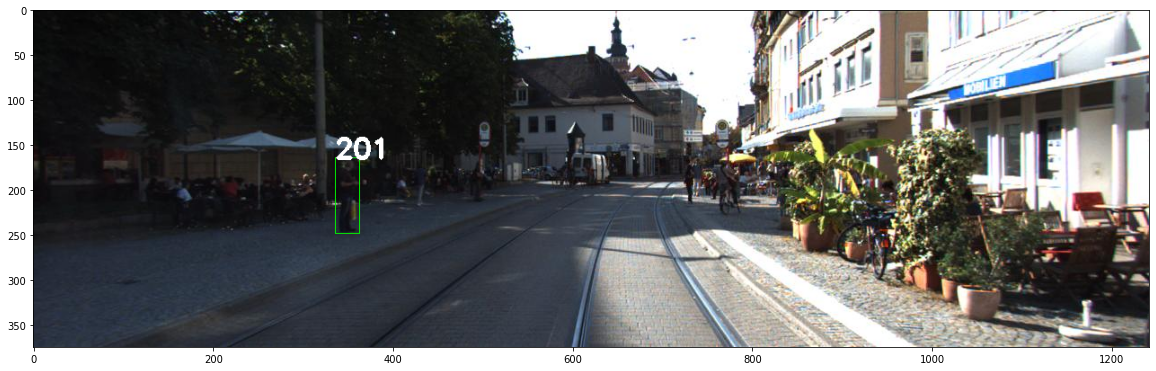

In [15]:
seq, imgid = 'KITTI-13', 56

img = cv2.imread(f'/kaggle/MOT15/images/train/{seq}/img1/{imgid:06d}.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

annot = pd.read_csv(f'/kaggle/MOT15/labels_with_ids/train/{seq}/img1/{imgid:06d}.txt', 
                    header=None, sep=' ', usecols=range(1,6))
annot_ltrb = pd.concat(
    [
        annot.loc[:, 1],
        annot.loc[:, 2] - 0.5 * annot.loc[:, 4],
        annot.loc[:, 3] - 0.5 * annot.loc[:, 5],
        annot.loc[:, 2] + 0.5 * annot.loc[:, 4],
        annot.loc[:, 3] + 0.5 * annot.loc[:, 5]
    ], 
    axis=1, 
    keys=['class_id', 'left', 'top', 'right', 'bot'])

annot_ltrb.loc[:, ['left', 'right']] *= img.shape[1]
annot_ltrb.loc[:, ['top', 'bot']] *= img.shape[0]

color = (0, 255, 0)
line_thickness = 1

for _, r in annot_ltrb.iterrows():
    r = r.astype(int)
    cv2.rectangle(img, 
                  (r['left'], r['top']), (r['right'], r['bot']), 
                  color, line_thickness)
    cv2.putText(img,
                str(r['class_id']),
                (r['left'], r['top']),
                cv2.FONT_HERSHEY_SIMPLEX,
                1., 
                (255, 255, 255), 
                thickness=3)

fig, ax = plt.subplots(figsize=(20, 8),)
ax.imshow(img);

In [16]:
# Looks like the seqs do not share any class ids.  
# Each class id is unique for the whole MOT15 collection.

seqs = os.listdir('/kaggle/MOT15/images/train')

for seq in seqs:
    class_ids = []
    for fn in os.listdir(f'/kaggle/MOT15/labels_with_ids/train/{seq}/img1'):
        annot = pd.read_csv(os.path.join(f'/kaggle/MOT15/labels_with_ids/train/{seq}/img1', fn), 
                            sep=' ', header=None, usecols=range(1, 6))
        class_ids.extend(list(annot.iloc[:, 0].values))
        
    print(f'{seq}:')
    print(f'class_ids:', np.array(set(class_ids)))
    print()

ETH-Sunnyday:
class_ids: {437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466}

ETH-Pedcross2:
class_ids: {304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436}

ETH-Bahnhof:
class_ids: {25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 5

# Training

In [17]:
from opts import opts
import src.train

Using tensorboardX


In [18]:
args = ['mot',
        '--root_dir', '/kaggle/working',
        '--exp_id', 'mot15_ft_mix_dla34', 
        '--load_model', '/kaggle/input/models-fairmot/fairmot_dla34.pth',
        '--num_epochs', '2',
        '--lr_step', '15', 
        '--data_cfg', '/kaggle/FairMOT/src/lib/cfg/mot15.json', 
        '--gpus', '0']

opt = opts().init(args)

Fix size testing.
training chunk_sizes: [12]
The output will be saved to  /kaggle/working/exp/mot/mot15_ft_mix_dla34
heads {'hm': 1, 'wh': 4, 'id': 128, 'reg': 2}


In [19]:
src.train.main(opt)

Setting up data...
dataset summary
OrderedDict([('mot15', 23.0)])
total # identities: 24
start index
OrderedDict([('mot15', 0)])
heads {'hm': 1, 'wh': 4, 'id': 128, 'reg': 2}
Namespace(K=500, arch='dla_34', batch_size=12, cat_spec_wh=False, chunk_sizes=[12], conf_thres=0.4, data_cfg='/kaggle/FairMOT/src/lib/cfg/mot15.json', data_dir='/home/zyf/dataset', dataset='jde', debug_dir='/kaggle/working/exp/mot/mot15_ft_mix_dla34/debug', dense_wh=False, det_thres=0.3, down_ratio=4, exp_dir='/kaggle/working/exp/mot', exp_id='mot15_ft_mix_dla34', fix_res=True, gpus=[0], gpus_str='0', head_conv=256, heads={'hm': 1, 'wh': 4, 'id': 128, 'reg': 2}, hide_data_time=False, hm_weight=1, id_loss='ce', id_weight=1, img_size=(1088, 608), input_h=608, input_res=1088, input_video='../videos/MOT16-03.mp4', input_w=1088, keep_res=False, load_model='/kaggle/input/models-fairmot/fairmot_dla34.pth', lr=0.0001, lr_step=[15], ltrb=True, master_batch_size=12, mean=None, metric='loss', min_box_area=100, mse_loss=False

Downloading: "http://dl.yf.io/dla/models/imagenet/dla34-ba72cf86.pth" to /root/.cache/torch/hub/checkpoints/dla34-ba72cf86.pth


  0%|          | 0.00/60.3M [00:00<?, ?B/s]

Starting training...


loaded /kaggle/input/models-fairmot/fairmot_dla34.pth, epoch 30


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
mot/mot15_ft_mix_dla34 |################################| train: [1][7/8]|Tot: 0:00:38 |ETA: 0:00:06 |loss 6.1823 |hm_loss 0.7294 |wh_loss 1.0227 |off_loss 0.2147 |id_loss 3.0145 |Data 0.003s(1.053s) |Net 4.797s 
mot/mot15_ft_mix_dla34 |################################| train: [2][7/8]|Tot: 0:00:32 |ETA: 0:00:05 |loss 4.6976 |hm_loss 0.4623 |wh_loss 0.9086 |off_loss 0.2020 |id_loss 2.6259 |Data 0.003s(0.996s) |Net 4.073s 


In [20]:
%cd /kaggle/working/exp/mot/
! zip -qr mot15_ft_mix_dla34.zip mot15_ft_mix_dla34/
! mv mot15_ft_mix_dla34.zip /kaggle/working/.

/kaggle/working/exp/mot
